# Laboratorio: Regressione Lineare

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Analisi di Regressione

- Un **_modello di regressione_** permette di ottenere una stima $\hat{y}$ del valore $y$ di una variabile _dipendente_ in base ai valori di una o più variabili _indipendenti_ $x_1,\ldots,x_n$
- Viene **addestrato** su osservazioni di cui si conoscono sia i valori $x_1,\ldots,x_n$ che $y$, in modo da minimizzare l'errore che compie su queste osservazioni
- Una volta addestrato, il modello può essere usato per effettuare **inferenze**, ovvero stime su nuovi dati e predizioni sul futuro
- La **regressione _lineare_** è un modello semplice ma spesso abbastanza efficace per ricavare modelli di predizione
- Possiamo implementare la regressione lineare tramite **_discesa gradiente_** con semplici operazioni tra vettori

## Caricamento Librerie

- Per l'esercitazione utilizzeremo le librerie viste finora
  - _NumPy_ per creare e operare su array a N dimensioni
  - _pandas_ per caricare e manipolare dati tabulari
  - _matplotlib_ per creare grafici
- Importiamo subito tutte le librerie usando i loro alias convenzionali

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- Abilitiamo l'inclusione dei grafici in Jupyter

In [2]:
%matplotlib inline

## Caso di Studio 1: Predizione del Consumo di Elettricità

- Per dimensionare adeguatamente le risorse, una compagnia elettrica deve predire giornalmente quanta corrente sarà consumata il giorno dopo
- Si ipotizza che nei mesi estivi una quota consistente di energia sia impiegata per l'aria condizionata
- La compagnia incrocia quindi i dati storici sul consumo con quelli sulla temperatura per indagare sul fenomeno...

## Caricamento dei Dati

- Prendiamo come esempio i dati relativi all'area di Pittsburgh negli USA
  - la compagnia elettrica rende disponibili dati storici sul consumo quì: https://dataminer2.pjm.com/feed/hrl_load_metered/definition
  - i dati sulle temperature registrate possono invece essere reperiti da quì: http://wefacts.org/
- Abbiamo raccolto i dati utili dal 2015 al 2017 in un file CSV con colonne _data_, _temperatura media_ (in gradi Celsius, °C), _picco di consumo_ (in gigawatt, GW)
- Eseguire la seguente cella per scaricare il file localmente

In [3]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

- Usiamo pandas per caricare i dati in un DataFrame dato l'URL del file
  - col parametro `parse_dates` si indica a pandas di interpretare i valori di una o più colonne indicate come date

In [4]:
data = pd.read_csv("power.csv", parse_dates=["date"])

In [5]:
data.head(3)

,date,demand,temp
0,2015-01-01,1.736065,1.7
1,2015-01-02,1.831672,2.2
2,2015-01-03,1.714934,14.4


In [6]:
data.tail(3)

,date,demand,temp
1093,2017-12-29,1.940514,-7.8
1094,2017-12-30,1.909027,-7.8
1095,2017-12-31,1.937984,-10.6


- Le colonne `demand` e `temp` contengono i dati veri e propri, mentre `date` indica la data a cui ciascuna riga si riferisce
- Ha senso quindi che `date` sia l'indice del DataFrame
- In `read_csv` possiamo usare l'opzione `index_col` per specificare che una o più colonne costituiscano l'indice del DataFrame
- In alternativa, senza ricaricare il file, usiamo `set_index` per impostare una colonna come indice
  - `inplace=True` specifica di modificare il DataFrame piuttosto che crearne una copia

In [7]:
data.set_index("date", inplace=True)

In [8]:
data.head(3)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4


## Selezione dei Dati

- Il dataset contiene i dati relativi agli interi anni tra il 2015 e il 2017, ma la nostra analisi è limitata (per il momento) ai mesi estivi
- Vogliamo selezionare dal DataFrame le sole righe relative a giugno, luglio e agosto di ciascun anno
- L'attributo `index` del DataFrame ci permette di accedere alle date delle singole righe
- Per indici di tipo data/ora come questo, pandas offre attributi per selezionare un singolo campo di ciascuna data
- Selezioniamo quindi il mese (da 1 a 12) di ciascuna data con `index.month`
  - oltre a `month` esistono `year`, `day`, `hour`, ...

In [9]:
data.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='date', length=1096)

- Possiamo quindi selezionare le righe di `data` in corrispondenza delle date il cui mese è compreso tra 6 (giugno) e 8 (agosto)
- Usiamo la selezione per righe con `loc`
  - NB: l'espressione tra quadre restituisce un array piuttosto che una serie, la selezione avviene per posizione delle righe piuttosto che per etichette

In [10]:
data_summer = data.loc[(data.index.month >= 6) & (data.index.month <= 8)]

- `data_summer` ha quindi le stesse colonne di `data` ma contiene solamente le righe d'interesse

In [11]:
data_summer.head(3)

,demand,temp
date,,
2015-06-01,1.640036,15.6
2015-06-02,1.663211,17.2
2015-06-03,1.728381,21.7


## Analisi delle Singole Variabili

- Analizziamo separatamente le distribuzioni dei valori di `demand` e `temp`
- Usiamo `describe` per ottenere le statistiche principali e i quartili

In [12]:
data_summer.describe()

,demand,temp
count,276.000000,276.000000
mean,2.184207,27.335507
std,0.308225,3.164825
min,1.496912,15.600000
25%,1.939613,25.000000
50%,2.196759,27.800000
75%,2.430171,29.400000
max,2.804025,33.900000


- Usiamo degli istogrammi per vedere dettagliatamente la distribuzione

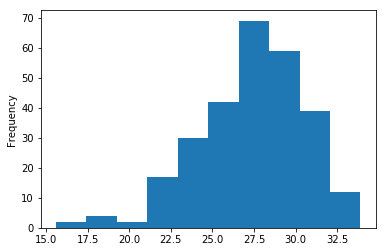

In [13]:
data_summer["temp"].plot.hist()

- La temperatura ha una distribuzione approssimativamente normale, con media intorno ai 27,5 °C

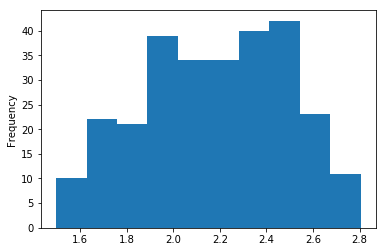

In [14]:
data_summer["demand"].plot.hist()

- La richiesta di corrente ha una distribuzione simile, con media intorno ai 2,2 GW

## Correlazione tra le Variabili

- Analizziamo ora la correlazione tra le due variabili
- Creiamo un grafico a dispersione, usando `temp` e `demand` rispettivamente come variabili X e Y

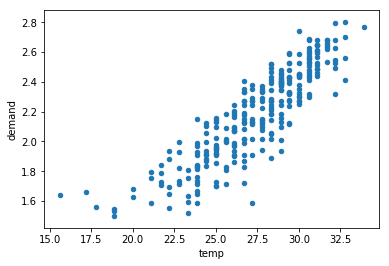

In [15]:
data_summer.plot.scatter("temp", "demand")

- Il grafico suggerisce che esista una correlazione tra le variabili: a valori alti (o bassi) della temperatura corrispondono valori alti (o bassi) del consumo

- Per quantificare la correlazione, possiamo calcolare il _coefficiente di correlazione di Pearson_ tra le due serie
- Date due variabili casuali $X$ e $Y$, il coefficiente è dato dal rapporto tra la loro covarianza $\sigma_{XY}$ e il prodotto delle deviazioni standard $\sigma_X$ e $\sigma_Y$
$$ \rho(X,Y) = \frac{\sigma_{XY}}{\sigma_X\sigma_Y} $$
- Data una serie di campioni $(x_1,y_1),\ldots,(x_n,y_n)$ delle due variabili con medie $\mu_X$ e $\mu_Y$, la correlazione si può stimare come
$$ \frac{\sum_{i=1}^n{(x_i-\mu_X)\cdot(y_i-\mu_Y)}}{n\cdot\sigma_X\cdot\sigma_Y} $$
- Il coefficiente ha un valore compreso tra 1 e -1, dove
  - valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X)
  - valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X)
  - valori vicini a 0 indicano assenza di correlazione

- Per brevità, estraiamo i due vettori di valori dal DataFrame ed assegniamoli a due variabili

In [16]:
temp = data_summer["temp"].values
demand = data_summer["demand"].values

- Usiamole quindi per calcolare la formula sopra

In [17]:
np.mean((temp-temp.mean()) * (demand-demand.mean())) / (temp.std() * demand.std())

0.876026184463451

- Il valore ottenuto conferma che esiste una forte correlazione tra le due variabili

## Regressione Lineare Univariata

- Con i dati disponibili, possiamo creare un modello di regressione per ottenere una stima $\hat{y}$ del consumo di corrente $y$ in base alla temperatura (prevista) $x$
- Dovendo prevedere il valore della variabile dipendente $y$ in base ad un'unica variabile indipendente $x$, la regressione è _univariata_
- La regressione lineare univariata genera un modello con due parametri $\alpha$ e $\beta$
$$ \hat{y} = h(x) = \alpha\cdot x+\beta $$
- L'obiettivo dell'analisi di regressione è trovare i valori di $\alpha$ e $\beta$ per cui il modello $h(x)$ approssimi quanto meglio possibile la correlazione tra consumi e temperatura

## Esempio di Modello di Regressione

- Si ipotizzi ad esempio di impostare arbitrariamente i parametri a $\alpha=0.2,\beta=-3$
- La funzione che approssima il consumo in base alla temperatura $x$ sarebbe $h(x)=0.2\cdot x-3$
- Possiamo definire tale funzione in Python:

In [18]:
def sample_model(x):
    return 0.2 * x - 3

- Ad es. per una temperatura di 25 °C sarebbe previsto un picco di consumi in GW di:

In [19]:
sample_model(25)   # = 0.2 * 25 - 3 =

2.0

- Dato che gli operatori sono compatibili, tale funzione si può applicare per vettori: passando come argomento un vettore di valori X otteniamo un vettore di corrispondenti valori Y

In [20]:
sample_model(np.array([20, 25, 30]))

array([1., 2., 3.])

- Per comodità, creiamo una funzione di _ordine superiore_, che dati i parametri `alpha` e `beta` restituisca a sua volta una funzione che implementa il modello con tali parametri

In [21]:
def make_model(alpha, beta):
    def model(x):
        return alpha * x + beta
    return model

- Ad es., per ottenere il modello dell'esempio precedente:

In [22]:
sample_model = make_model(0.2, -3)

In [23]:
sample_model(25)

2.0

In [24]:
sample_model(np.array([20, 25, 30]))

array([1., 2., 3.])

## Grafico del Modello di Regressione

- Un modello di regressione lineare univariata $h(x)=\alpha\cdot x+\beta$ è rappresentabile come una retta in un piano
- Possiamo quindi disegnare un grafico di tale modello
- Come metodo generale per disegnare il grafico di una funzione in matplotlib, generiamo un vettore di valori di x possibili e applichiamo ad esso la funzione per ottenere i corrispondenti valori y
- Creiamo un vettore di N valori x distribuiti linearmente in un intervallo con la funzione `linspace` di NumPy

In [25]:
plot_x = np.linspace(15, 35, 100)

- Usiamo quindi la funzione `plot` di matplotlib per tracciare il grafico, passando il vettore di x e le y corrispondenti
  - il grafico viene tracciato congiungendo i campioni dati della funzione
  - trattandosi di una retta sarebbero bastati i due punti estremi, ma questo approccio funziona anche su curve
- Aggiungiamo al grafico una griglia e le etichette degli assi per facilitarne la lettura

Text(0, 0.5, 'Consumi previsti (GW)')

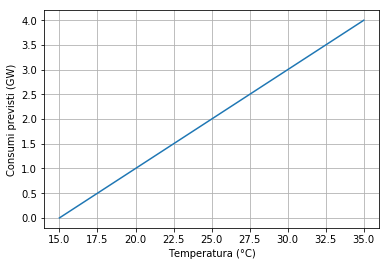

In [26]:
plt.plot(plot_x, sample_model(plot_x))
plt.grid()
plt.xlabel("Temperatura (°C)")
plt.ylabel("Consumi previsti (GW)")

- Il grafico conferma ad es. come visto sopra che a fronte di una temperatura di 25 °C il modello prevede 2 GW di consumi

- Per avere un'idea di quanto il modello sia accurato, possiamo sovrapporlo al grafico a dispersione dei dati
  - per far sì che il grafico sia "zoomato" sui dati, usiamo le funzioni `xlim` e `ylim` per impostare manualmente i limiti a quelli usati da matplotlib per il grafico sui soli dati

Text(0, 0.5, 'Consumi previsti (GW)')

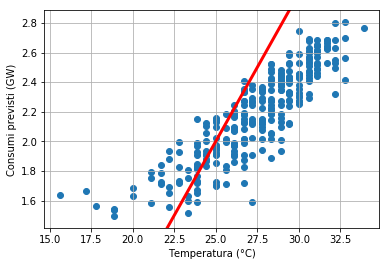

In [27]:
plt.scatter(temp, demand)
xlim, ylim = plt.xlim(), plt.ylim()
plot_x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(plot_x, sample_model(plot_x), lw=3, c="red")
plt.xlim(xlim); plt.ylim(ylim)
plt.grid()
plt.xlabel("Temperatura (°C)")
plt.ylabel("Consumi previsti (GW)")

- Definiamo una funzione che produca tale grafico su dati e modello arbitrari

In [28]:
def plot_model_on_data(x, y, model=None):
    plt.scatter(x, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        plot_x = np.linspace(xlim[0], xlim[1], 100)
        plt.plot(plot_x, model(plot_x), lw=3, c="red")
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Consumi previsti (GW)")

- In questo modo possiamo ottenere il grafico desiderato semplicemente con:

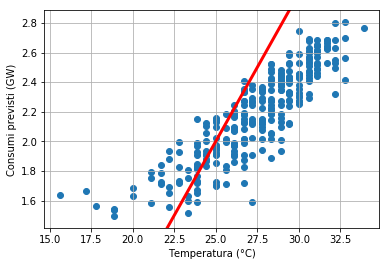

In [29]:
plot_model_on_data(temp, demand, sample_model)

- Confrontando il modello con i dati reali, si può vedere che le predizioni non sono accurate, in particolare per temperature molto alte o molto basse

## Errore del Modello

- Come quantificare l'errore che un modello $h$ compie rispetto ai dati reali?
- La metrica usata più comunemente è l'_errore quadratico medio_ (_mean squared error_, MSE), ovvero la media dei quadrati delle differenze tra ciascun valore reale $y_j$ e la corrispondente predizione $\hat{y_j}=h(x_j)$
$$ E=\frac{1}{m}\sum_{j=1}^m\left(h(x_j)-y_j\right)^2 $$
- In forma vettoriale:
$$ E=\mathrm{media}\left(\left(\mathbf{\hat{y}}-\mathbf{y}\right)^2\right) $$

- Ad esempio, calcoliamo l'errore del modello considerato sopra con parametri $\alpha=0.2,\beta=-3$
- Otteniamo le predizioni del modello (ovvero il vettore $\mathbf{\hat{y}}$)

In [30]:
predicted_demand = sample_model(temp)

- Applichiamo quindi la formula per calcolare l'errore

In [31]:
#  Mean   Squared Error
np.mean(np.square(predicted_demand - demand))

0.23330138712973206

- Questo valore può essere confrontato con quello di altri modelli: minore è l'errore, più accurato è il modello

## Esercizi A: Modelli ed Errore

Usare le funzioni definite sopra per:
- **1)** creare un modello di regressione univariata lineare con $\alpha=0.15$ e $\beta=-1$
- **2)** predire i consumi di energia a fronte di temperature di 20, 25 e 30 °C
- **3)** visualizzare tale modello come linea in un grafico, sovrapposto al grafico a dispersione dei dati
- **4)** calcolare l'errore quadratico medio compiuto dal modello e valutare se sia più o meno accurato di quello sopra

## Errore in Funzione dei Parametri

- La formulazione data sopra del MSE è indipendente dal modello specifico
$$ E=\frac{1}{m}\sum_{j=1}^m\left(h(x_j)-y_j\right)^2 $$
- Dato il modello $h(x)=\alpha\cdot x+\beta$, possiamo esprimere l'errore in funzione dei parametri del modello $\alpha$ e $\beta$
  - i dati $(x_1,y_1),\ldots,(x_m,y_m)$ su cui l'errore è calcolato sono fissati a priori
$$ E(\alpha,\beta)=\frac{1}{m}\sum_{j=1}^m\left(\alpha\cdot x_j+\beta-y_j\right)^2 $$
- Scritto in forma vettoriale:
$$ E(\alpha,\beta)=\mathrm{media}\left(\left(\alpha\cdot\mathbf{x}+\beta-\mathbf{y}\right)^2\right) $$

- Ad esempio, riprendendo il modello d'esempio con parametri $\alpha=0.2,\beta=-3$, possiamo calcolarne il MSE con:

In [32]:
np.mean(np.square(0.2 * temp - 3 - demand))

0.23330138712973206

- Il risultato è lo stesso ottenuto sopra col calcolo sulla funzione `sample_model`
- Possiamo definire una funzione Python che calcoli l'errore dati i parametri
  - in `mean` specifichiamo `axis=-1` per calcolare la media solo lungo l'ultima dimensione: questo ci permetterà di calcolare l'errore per più valori dei parametri

In [33]:
def ulr_mse(x, y, alpha, beta):
    return np.mean(np.square(alpha * x + beta - y), axis=-1)

- Testiamo la funzione sui parametri d'esempio

In [34]:
ulr_mse(temp, demand, 0.2, -3)

0.23330138712973206

## Grafico della Funzione d'Errore

- Visualizziamo l'errore in funzione dei parametri in un grafico 3D
  - due dimensioni rappresentano i parametri, la terza l'errore
- Come per il grafico 2D sopra, estraiamo un insieme di campioni della funzione per visualizzarne il grafico
- Per prima cosa, usiamo `linspace` per definire campioni di valori per i parametri $\alpha$ (alpha) e $\beta$ (beta) singolarmente

In [35]:
plot_alpha = np.linspace(-.3, .3, 101)
plot_beta = np.linspace(-4, 4, 101)

- Usiamo quindi la funzione `mse` per calcolare l'errore per tutte le combinazioni possibili di valori di $\alpha$ e $\beta$
  - riformiamo i vettori a matrici 3D, le cui dimensioni corrispondono a: valori $\alpha$, valori $\beta$, dati
  - l'ultima dimensione è ridotta calcolando la media: otteniamo una matrice 2D con l'MSE per ogni combinazione dei parametri

In [36]:
plot_mse = ulr_mse(temp, demand, plot_alpha[:, None, None], plot_beta[None, :, None])

- Abilitiamo la creazione di grafici 3D in matplotlib tramite il seguente import

In [37]:
from mpl_toolkits import mplot3d

- Usiamo quindi l'API ad oggetti di matplotlib per creare il grafico
  - `plt.figure` restituisce un oggetto "figura" di dimensioni impostabili che può contenere più grafici
  - il metodo `add_subplot` della figura inserisce un singolo grafico, che può essere impostato come 3D
  - il metodo `plot_wireframe` del grafico disegna la funzione date 3 matrici 2D con rispettivamente le coordinate X, Y e Z dei campioni della funzione
  - i parametri `rstride` e `cstride` controllano quanto sono fitte le curve che delineano la superficie della funzione
  - i metodi `set_*label` impostano le etichette degli assi

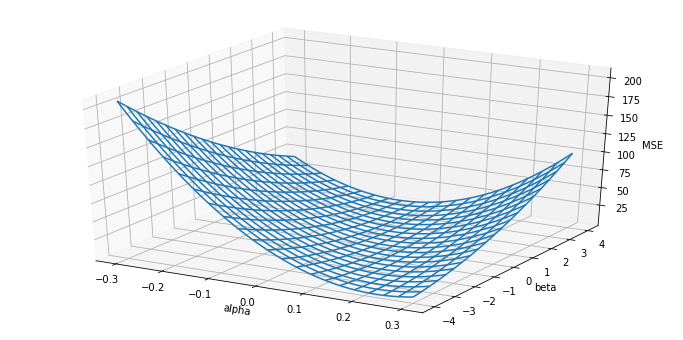

In [38]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(plot_alpha[:,None], plot_beta[None,:], plot_mse, rstride=5, cstride=5)
ax.set_xlabel("alpha"); ax.set_ylabel("beta"); ax.set_zlabel("MSE");

- Si può notare come esista un minimo nella curva dell'errore e come il valore dell'errore cresca allontanandosi da tale minimo

## Discesa del Gradiente

- Il _gradiente_ di una funzione indica la direzione in cui la curva della funzione stessa è maggiormente "inclinata"
  - il gradiente è il vettore delle _derivate parziali_ per ogni variabile
- Ad esempio il gradiente della funzione errore riportata sopra in funzione di $\alpha$ e $\beta$ è dato da:
$$ \nabla E(\alpha,\beta)=\left(\frac{\delta E}{\delta\alpha},\frac{\delta E}{\delta\beta}\right) $$
$$ \frac{\delta E}{\delta\alpha}=\frac{2}{m}\sum_{j=1}^m(\alpha\cdot x_j+\beta-y_j)\cdot x_j \qquad \frac{\delta E}{\delta\beta}=\frac{2}{m}\sum_{j=1}^m(\alpha\cdot x_j+\beta-y_j) $$
- L'algoritmo di _discesa del gradiente_, partendo da valori arbitrari di $\alpha$ e $\beta$, segue progressivamente il gradiente di $E$ per trovarne il minimo
- Fissata una lunghezza del passo $\eta$, ad ogni passaggio $\alpha$ e $\beta$ sono iterativamente aggiornati come segue:
$$ \alpha\leftarrow\alpha-\eta\cdot\frac{\delta E}{\delta\alpha} \qquad \beta\leftarrow\beta-\eta\cdot\frac{\delta E}{\delta\beta} $$
- In termini vettoriali, ponendo $\theta=(\alpha,\beta)$:
$$ \theta\leftarrow\theta-\eta\cdot\nabla E(\theta) $$

- Definiamo in Python una funzione `ulr_gd_step` che esegua un singolo passaggio della discesa gradiente basandosi sui dati che stiamo usando
  - in ingresso sono passati i valori di $\alpha$ e $\beta$ attuali e la lunghezza del passo
  - la derivata dell'errore viene calcolata sui parametri dati
  - i nuovi valori di $\alpha$ e $\beta$ sono calcolati e restituiti

In [39]:
def ulr_gd_step(x, y, alpha, beta, step_size):
    # calcolo il vettore degli errori nei dati
    error = alpha * x + beta - y
    # calcolo le derivate parziali del MSE
    d_alpha = 2 * (error * x).mean()
    d_beta = 2 * error.mean()
    # calcolo alpha e beta aggiornati
    new_alpha = alpha - step_size * d_alpha
    new_beta = beta - step_size * d_beta
    return new_alpha, new_beta

- Usiamo ora questa funzione in un ciclo per eseguire una discesa completa
- Partiamo da valori di $\alpha$ e $\beta$ arbitrari

In [40]:
alpha = 0
beta = 0

- Per verificare in seguito la progressione della discesa, creiamo delle liste che conterrano in sequenza i valori di $\alpha$ e $\beta$ testati, compresi i valori iniziali

In [41]:
alpha_vals = [alpha]
beta_vals = [beta]

- Eseguiamo ora la discesa gradiente, chiamando la funzione `ulr_gd_step` per un numero prefissato di volte e salvando i valori di `alpha` e `beta` ad ogni passo

In [42]:
for iteration in range(20):
    # esegui un passo di discesa e aggiorna i parametri
    alpha, beta = ulr_gd_step(temp, demand, alpha, beta, 0.001)
    # salva i valori correnti dei parametri
    alpha_vals.append(alpha)
    beta_vals.append(beta)

- Quali sono i valori di $\alpha$ e $\beta$ alla fine della discesa?

In [43]:
alpha

0.07987353337320882

In [44]:
beta

0.0028039969677238347

- Creiamo un modello basato su questi parametri

In [45]:
gd_model = make_model(alpha, beta)

- Visualizziamone la retta sovrapposta ai dati

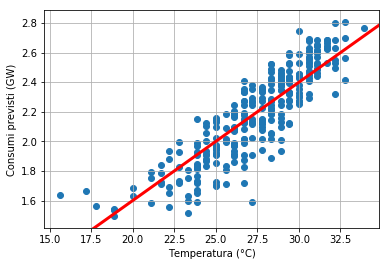

In [46]:
plot_model_on_data(temp, demand, gd_model)

- Calcoliamo il MSE del modello, indifferentemente usando `gd_model` oppure la funzione `mse` con i parametri

In [47]:
np.mean(np.square(gd_model(temp) - demand))

0.02231517217467159

In [48]:
ulr_mse(temp, demand, alpha, beta)

0.02231517217467159

- Questo è l'errore _ottimo_ individuato tramite la discesa gradiente
- Ogni passaggio della discesa ha ridotto il MSE gradualmente fino a convergere ai valori finali
- Per verificare ciò, convertiamo le progressioni dei valori di $\alpha$ e $\beta$ in vettori e usiamo questi per calcolare la progressione del MSE

In [49]:
alpha_vals = np.array(alpha_vals)
beta_vals = np.array(beta_vals)
mse_vals = ulr_mse(temp, demand, alpha_vals[:, None], beta_vals[:, None])

- Visualizziamo in un grafico l'andamento del MSE
  - la stringa `"ro-"` indica lo stile del grafico: linea (`-`) rossa (`r`) con punti (`o`)

Text(0, 0.5, 'MSE')

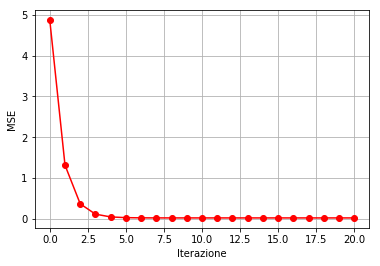

In [50]:
plt.plot(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("MSE")

- Per visualizzare meglio l'andamento per valori piccoli, applichiamo una scala logaritmica all'asse Y, usando la funzione `semilogy` al posto di `plot`

Text(0, 0.5, 'MSE')

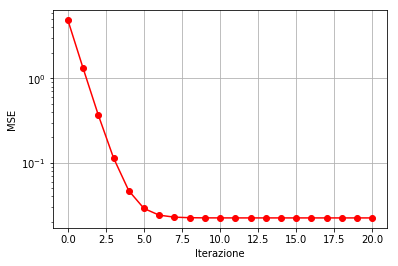

In [51]:
plt.semilogy(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("MSE")

- Vediamo tale progressione anche sul grafico 3D dell'errore, evidenziando (in rosso) i parametri testati da un passaggio all'altro e i corrispondenti MSE
  - cambiamo gli intervalli di valori `plot_alpha` e `plot_beta` per "zoomare" sul grafico

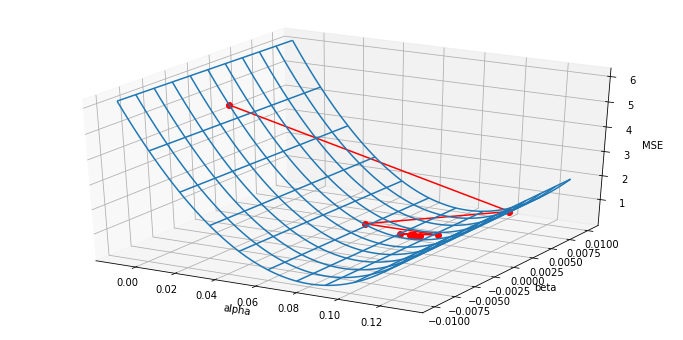

In [52]:
plot_alpha = np.linspace(-0.01, 0.13, 101)
plot_beta = np.linspace(-0.01, 0.01, 101)
plot_mse = ulr_mse(temp, demand, plot_alpha[:, None, None], plot_beta[None, :, None])
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(plot_alpha[:,None], plot_beta[None,:], plot_mse, rstride=10, cstride=10)
ax.plot(alpha_vals, beta_vals, mse_vals, "o-", c="red")
ax.set_xlabel("alpha"); ax.set_ylabel("beta"); ax.set_zlabel("MSE");

- Possiamo usare in alternativa una visualizzazione 2D, dove le zone più scure corrispondono ad errore maggiore

Text(0, 0.5, 'beta')

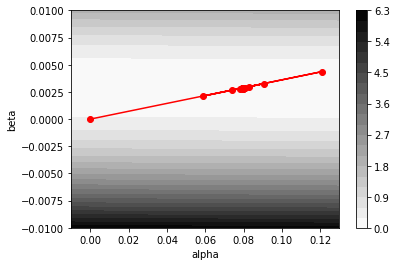

In [53]:
from matplotlib.ticker import LogLocator
plt.contourf(plot_alpha, plot_beta, plot_mse, levels=20, cmap="gray_r")
plt.colorbar()
plt.plot(alpha_vals, beta_vals, "ro-")
plt.xlabel("alpha")
plt.ylabel("beta")

- Si può vedere come, partendo da un punto arbitrario, con la discesa gradiente ci siamo progressivamente avvicinati al punto con errore minimo

- Possiamo infine vedere i grafici dei modelli ottenuti nei passaggi intermedi della discesa gradiente
- Vediamo ad esempio il modello ottenuto dopo un solo passaggio, recuperando i valori dei parametri dalle progressioni

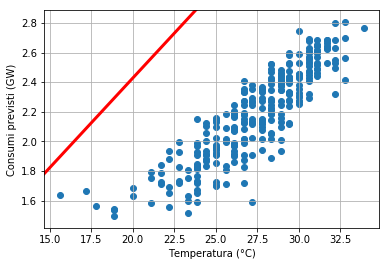

In [54]:
plot_model_on_data(temp, demand, make_model(alpha_vals[1], beta_vals[1]))

- Dopo 2 passaggi

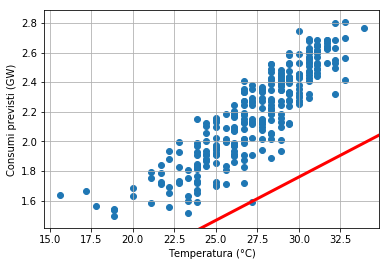

In [55]:
plot_model_on_data(temp, demand, make_model(alpha_vals[2], beta_vals[2]))

- Dopo 3 passaggi

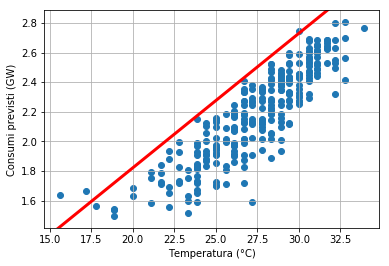

In [56]:
plot_model_on_data(temp, demand, make_model(alpha_vals[3], beta_vals[3]))

- Dopo 4 passaggi

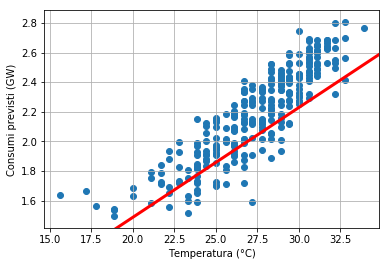

In [57]:
plot_model_on_data(temp, demand, make_model(alpha_vals[4], beta_vals[4]))

- Dopo 5 passaggi

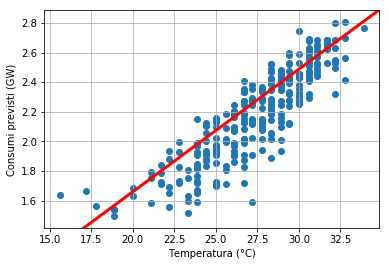

In [58]:
plot_model_on_data(temp, demand, make_model(alpha_vals[5], beta_vals[5]))

- Dopo 10 passaggi

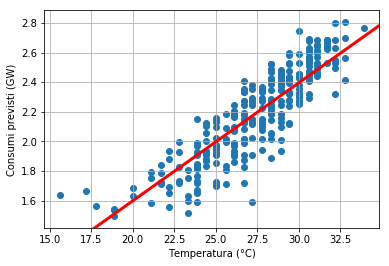

In [59]:
plot_model_on_data(temp, demand, make_model(alpha_vals[10], beta_vals[10]))

## Esercizi B: Analisi dei Mesi Invernali

- Finora abbiamo svolto l'analisi sui mesi estivi, imputando una parte consistente di consumo di elettricità all'aria condizionata
- Analogamente, ipotizziamo che nei mesi invernali una quota importante di elettricità sia consumata per il riscaldamento (es. stufe elettriche) in modo dipendente dalla temperatura
- Estraiamo questa volta i dati relativi ai mesi di dicembre, gennaio e febbraio

In [60]:
data_winter = data.loc[(data.index.month <= 2) | (data.index.month >= 12)]

Riutilizzando le funzioni definite sopra dove necessario:
- **1.** visualizzare i dati in un grafico a dispersione
- **2.** addestrare un modello di regressione con 300 iterazioni di discesa gradiente con lunghezza del passo 0,01
- **3.** visualizzare il modello estratto sovrapposto ai dati
- **4.** usando il modello, prevedere il picco di consumo che si avrebbe con una temperatura di -5 °C

## Caso di Studio 2: Predizione Valori delle Case nei Quartieri

- Un'agenzia immobiliare deve determinare i prezzi delle case in vendita
- Un aspetto importante per determinare il prezzo è il quartiere in cui la casa si trova
- Per ogni quartiere si possono individuare delle caratteristiche sommarie
  - dati demografici, posizione, tasse, criminalità, ...
- In base a queste caratteristiche, si vuole determinare il prezzo ideale dell'abitazione "media" di qualsiasi quartiere

## Dati d'Esempio

- Il dataset _Housing_, usato in ricerca e disponibile sul Web, contiene informazioni sui quartieri residenziali di Boston
- I dati possono essere reperiti al seguente URL:

In [61]:
housing_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"

- I dati sono disposti in colonne di larghezza fissa, separate con spazi, senza una riga di intestazione
```
 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00
 0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80 396.90   9.14  21.60
 0.02729   0.00   7.070  0  0.4690  7.1850  61.10  4.9671   2  242.0  17.80 392.83   4.03  34.70
...
```
- Possiamo considerarlo come un CSV dove è usato un numero variabile di spazi come separatore
  - usiamo l'espressione regolare "`\s+`" che indica "uno o più spazi"

In [62]:
housing = pd.read_csv(housing_url, header=None, sep="\s+")

- Quante righe e colonne contiene il file importato?

In [63]:
housing.shape

(506, 14)

- Non essendoci una riga di header, dobbiamo impostare manualmente i nomi delle colonne

In [64]:
housing.columns = "CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV".split()

In [65]:
housing.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


### Lista delle variabili

- CRIM: tasso di criminalità pro capite per zona
- ZN: proporzione terreno residenziale per lotti maggiori di 25.000 piedi quadrati (circa 2300 m2)
- INDUS: proporzione di acri industriali non commerciali per città
- CHAS: variabile fittizia Charles River, 1 se il tratto affianca il fiume, altrimenti 0
- NOX: concentrazione di ossido d’azoto (parti per 10 milioni)
- RM: numero medio di stanze per abitazione
- AGE: proporzione delle unità abitate costruite prima del 1940
- DIS: distanze pesate verso i cinque uffici di collocamento di Boston
- RAD: indice di accessibilità rispetto alle grandi vie radiali di comunicazione
- TAX: tasso di imposte sulla casa per 10.000 dollari
- PTRATIO: rapporto allievi-docenti per città
- B: 1000(Bk - 0.63)2, dove Bk è la proporzione di persone di origine afroamericana
- LSTAT: percentuale di popolazione con basso reddito
- **MEDV: valore mediano delle abitazioni di proprietà in migliaia di dollari**
  - vogliamo stimare il valore di questa variabile in funzione delle altre

## Regressione Lineare Multivariata

- Nella regressione multivariata una variabile dipendente è stimata su $n$ variabili indipendenti
- Il modello è rappresentabile come un iperpiano in $n+1$ dimensioni con $n+1$ parametri ($n$ coefficienti angolari più l'intercetta)
$$ h(\mathbf{x})=\theta_0+\sum_{i=1}^n\theta_i\cdot x_i=\mathbf{\theta}\cdot([1]\Vert\mathbf{x}) $$
- Un insieme di $m$ osservazioni su cui addestrare il modello può essere rappresentato da
  - una matrice $\mathbf{X}$ con $m\times n$ valori delle variabili indipendenti
  - un vettore $\mathbf{y}$ con i corrispondenti $m$ valori noti della variabile dipendente

## Dati per la Regressione

- Dobbiamo estrarre dai dati caricati la matrice X e il vettore y
- y è dato dalla colonna `MEDV` del frame
  - con `values` si estrae l'array dei valori contenuti in una serie o frame

In [66]:
y = housing["MEDV"].values

- X è dato dall'intero frame ad esclusione della colonna `MEDV`
  - usiamo il metodo `drop` per ottenere una copia del frame senza la colonna

In [67]:
X = housing.drop(columns=["MEDV"]).values

- Creiamo anche una matrice X1 dove a sinistra di X è aggiunta una colonna di 1, usando la funzione `hstack` ("horizontal stack") che concatena due matrici date

In [68]:
X1 = np.hstack([np.ones((X.shape[0], 1)), X])

## Discesa del Gradiente

- Come sopra implementiamo la discesa gradiente per trovare un modello ottimo, questa volta adattandola al caso multivariato
- Creiamo una funzione `lr_gd_step` modificata rispetto a sopra
  - invece di due parametri `alpha` e `beta` si ha un vettore `theta` di n+1 parametri
  - il calcolo avviene tra matrici (NB: `matrice.dot(vettore)` restituisce un vettore dei prodotti scalari di ciascuna riga della matrice col vettore)

In [69]:
def lr_gd_step(X1, y, theta, step_size):
    # calcolo l'errore su ciascun dato d'esempio
    error = X1.dot(theta) - y
    # calcolo il gradiente dell'errore, ovvero
    # la derivata parziale di ciascun parametro
    grad = 2 / X1.shape[0] * (X1.T.dot(error))
    # calcolo il nuovo valore di tutti i parametri
    new_theta = theta - step_size * grad
    return new_theta

- Utilizziamo la funzione in un ciclo per eseguire la discesa gradiente
  - come prima, partiamo da valori nulli e salviamo i parametri intermedi in una lista

In [70]:
theta = np.zeros(X1.shape[1])
theta_vals = [theta]
for iteration in range(50):
    theta = lr_gd_step(X1, y, theta, 0.000001)
    theta_vals.append(theta)
theta_vals = np.array(theta_vals)

- Abbiamo così ottenuto un vettore `theta` dei parametri del modello trovati con la discesa

In [71]:
theta

array([ 1.73529211e-04, -1.87115118e-03,  9.01220381e-03, -8.92497963e-04,
        4.90578112e-05,  5.65559423e-05,  1.53364533e-03,  2.98741959e-03,
        1.06583412e-03, -1.07105208e-03,  1.82357233e-03,  2.19566708e-03,
        5.80886512e-02, -2.17989416e-03])

## Inferenza

- Sia dato un vettore di valori delle variabili indipendenti, ad esempio la prima riga di X

In [72]:
sample = X[0]

- Per calcolare il valore previsto di y, applichiamo la formula del modello lineare multivariato

In [73]:
theta[0] + theta[1:].dot(sample)

23.986402721555702

- Per confronto, il valore reale è

In [74]:
y[0]

24.0

## Errore del Modello

- Calcoliamo il MSE compiuto dal modello sui dati
$$ E = \mathrm{media}\left(\left(h(\mathbf{x})-y\right)^2\right) = \mathrm{media}\left(\left(\mathbf{\theta}\cdot([1]\Vert\mathbf{x})-y\right)^2\right) $$

In [75]:
np.mean(np.square(X1.dot(theta) - y))

81.01326863928051

- Dalla progressione dei valori dei parametri, calcoliamo quella del MSE e visualizziamola in un grafico

In [76]:
mse_vals = np.mean(np.square(X1.dot(theta_vals.T) - y[:, None]), axis=0)

Text(0, 0.5, 'MSE')

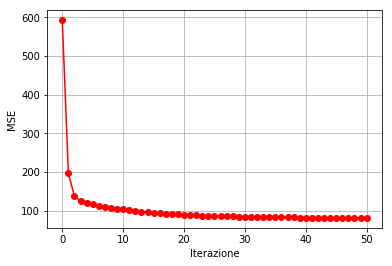

In [77]:
plt.plot(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("MSE")

- Come prima, l'errore converge gradualmente al valore minimo a cui arriva all'ultima iterazione

## scikit-learn

- Invece di implementare manualmente l'addestramento e l'uso di modelli, vediamo come usare una libreria apposita...
- _scikit-learn_ offre diversi algoritmi e funzioni di supporto per l'addestramento di modelli predittivi, inclusa la regressione lineare
  - tutti i tipi di modelli offrono un'interfaccia comune per l'addestramento e la predizione (_inferenza_)
  - i dati in ingresso sono rappresentati come array NumPy o serie/frame pandas

## Addestramento di un Modello

- Vediamo ad esempio come addestrare un modello sul primo caso di studio, la predizione del consumo di corrente dalla temperatura nei mesi estivi
- Per addestrare un modello di regressione con scikit-learn, dapprima creiamo un oggetto modello "vuoto"

In [78]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

- Quindi usiamo il metodo `fit` per addestrarlo su un insieme di $m$ osservazioni, di cui sono date in input:
  - una matrice o DataFrame di $m\times n$ valori delle variabili indipendenti
  - un vettore o serie di $m$ valori della variabile dipendente
- Nel caso univariato, un vettore o serie di valori di $x$ va esplicitamente convertito in matrice o DataFrame $m\times 1$ per specificare che si tratta di $m$ osservazioni di 1 variabile
  - selezionando la colonna da un DataFrame, selezioniamo una lista di 1 colonne per ottenere un DataFrame di 1 colonna piuttosto che una serie

In [79]:
#       X: DF di una colonna   y: serie
lrm.fit(data_summer[["temp"]], data_summer["demand"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Inferenza

- Una volta che il modello è addestrato, possiamo ottenere predizioni col metodo `predict`
  - va data in input una matrice o DataFrame $m\times n$ di osservazioni delle variabili indipendenti
  - è restituito un vettore di $m$ valori della variabile dipendente previsti dal modello
- Ad esempio, passiamo gli stessi dati usati per l'addestramento per vedere le predizioni del modello

In [80]:
predictions = lrm.predict(data_summer[["temp"]])

- Vediamo alcuni dei valori predetti

In [81]:
predictions[:5]

array([1.1829682 , 1.31947545, 1.7034021 , 1.9849483 , 2.22383599])

- `predict` restituisce sempre un array NumPy, per ottenere una serie pandas è necessario applicare manualmente le etichette
  - in genere si possono copiare quelle delle righe del DataFrame dato in input

In [82]:
predictions = pd.Series(predictions, index=data_summer.index)

In [83]:
predictions.head()

date
2015-06-01    1.182968
2015-06-02    1.319475
2015-06-03    1.703402
2015-06-04    1.984948
2015-06-05    2.223836
dtype: float64

## Parametri del Modello

- Una volta addestrato il modello possiamo consultarne i parametri tramite due attributi:
  - `coef_` restituisce un array dei coefficienti angolari (uno solo nel caso univariato)
  - `intercept_` restituisce il valore dell'intercetta

In [84]:
lrm.coef_

array([0.08531703])

In [85]:
lrm.intercept_

-0.14797750194929682

- Questi sono in pratica i valori $\alpha$ e $\beta$ del modello lineare univariato $h(x)=\alpha\cdot x+\beta$

- Il valore di $\alpha$ di questo modello è (circa) uguale a quello ottenuto sopra, mentre quello di $\beta$ è diverso
- Vediamo l'errore di questo modello utilizzando le predizioni estratte e compariamolo con quello precedente

In [86]:
np.mean(np.square(predictions - data_summer["demand"]))

0.022015530001979786

- L'errore è leggermente inferiore rispetto a quello ottenuto sopra con la discesa gradiente
- scikit-learn calcola i parametri che minimizzano l'errore in modo analitico, per cui la soluzione sarà sempre migliore di (o uguale a) quella ottenuta con la discesa gradiente
- La discesa gradiente torna però utile in problemi più complessi non risolvibili analiticamente, ad es. l'addestramento di reti neurali

## Modello sui Prezzi delle Case

- Addestriamo ora un modello sul secondo dataset caricato, quello dei prezzi delle case
- Come sopra, creiamo un modello inizialmente vuoto

In [87]:
lrm = LinearRegression()

- Usiamo quindi `fit` per addestrare il modello, data la matrice delle variabili indipendenti e il vettore di quella dipendente, salvati in precedenza nelle variabili X  y

In [88]:
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- Possiamo usare `predict` per ottenere le predizioni che il modello effettua sugli stessi dati

In [89]:
y_pred = lrm.predict(X)

- Con tali predizioni possiamo calcolare l'errore compiuto dal modello

In [90]:
np.mean(np.square(y_pred - y))

21.894831181729206

- L'errore in questo caso è nettamente inferiore a quello ottenuto con la discesa gradiente

- Come sopra, possiamo ottenere dall'attributo `coef_` i coefficienti angolari usati dal modello
- Creando una serie possiamo associare ad ogni coefficiente angolare il nome della variabile corrispondente, per capire quali fenomeni influiscano positivamente e negativamente

In [91]:
pd.Series(lrm.coef_, index=housing.columns[:-1])

CRIM       -0.108011
ZN          0.046420
INDUS       0.020559
CHAS        2.686734
NOX       -17.766611
RM          3.809865
AGE         0.000692
DIS        -1.475567
RAD         0.306049
TAX        -0.012335
PTRATIO    -0.952747
B           0.009312
LSTAT      -0.524758
dtype: float64

- Vediamo ad esempio che il modello prevede il valore mediano delle abitazioni:
  - più alto di circa 2.700 dollari nei quartieri vicini al fiume (variabile CHAS)
  - circa 3.800 dollari più alto per ciascuna stanza (variabile RM)

## Esercizio C: Valutazione Modello con Metodo Hold-Out

- Dall'analisi di regressione dobbiamo ottenere un modello generale, che dia stime affidabili anche su dati simili ma diversi da quelli su cui è costruito
- Per questo è necessario **valutare** come si comporta il modello **su un insieme di dati separato** da quello usato per l'addestramento
- Il metodo _hold-out_ prevede che i dati a disposizione siano suddivisi a priori in
  - un _training set_ su cui il modello è effettivamente addestrato, minimizzando l'errore su di esso
  - un _validation set_ su cui verificare l'errore del modello
- **1)** creare due selezioni di righe del DataFrame `housing`
  - selezionare le prime 400 righe da usare come training set
  - selezionare le righe restanti da usare come validation set
- **2)** addestrare un modello di regressione lineare sul training set
- **3)** valutare il MSE del modello sia sul training set che sul validation set